# We need to demonstrate how meal was defined in our experiment; first we show KDE plot of ipi-s which justifies the temporal criterion of 60 sec max threshold for interval between cluster of pellets(feeding events). 
# Second, we will show the number of pellets that were taken within those density estimations, such that we can cluster the feeding events to Snacks , meals and feasts

In [2]:
import csv
from datetime import datetime
import numpy as np
import trompy as tp

def get_FEDevents(filename, eventname):
    formats = ['%Y-%m-%d %H:%M:%S', '%m/%d/%Y %H:%M:%S']
    
    try:
        file = open(filename)
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return []
    
    csvreader = csv.reader(file)
    next(csvreader)  # Skip header
    rows = []
    for row in csvreader:
        rows.append(row)

    # Check if rows are empty
    if len(rows) == 0:
        print(f"No data found in file: {filename}")
        return []

    # Determine which format should be used
    try:
        tmp_date_time_obj = datetime.strptime(rows[0][0], formats[0])
        date_format = formats[0]
    except ValueError:
        tmp_date_time_obj = datetime.strptime(rows[0][0], formats[1])
        date_format = formats[1]

    timestamps = []
    for row in rows: 
        if row[7] == eventname:  # Check event column
            date_time_obj = datetime.strptime(row[0], date_format)
            timestamps.append(date_time_obj)

    if len(timestamps) == 0:
        print(f"No {eventname} events found in file: {filename}")
        return []

    t0 = rows[0][0]
    day = t0.split()[0] 
    lightson = day + " 07:00:00"
    refpoint = datetime.strptime(lightson, date_format)
    
    pellettimes = []
    for t in timestamps:
        Deltat = t - refpoint
        Deltatinseconds = Deltat.total_seconds()
        Deltatinhours = Deltatinseconds / 3600
        pellettimes.append(Deltatinhours)

    return pellettimes
def get_data_subset(dictionary, selectors, verbose=True):
    output_dictionary = dictionary.copy()
    for key, value in selectors.items():
        for mouse_id in dictionary.keys():
            try:
                if output_dictionary[mouse_id][key] != value:
                    output_dictionary.pop(mouse_id)
            except KeyError: 
                pass

    if verbose:
        print("{} items in output dictionary".format(len(output_dictionary.keys())))
    
    return output_dictionary

def get_data_fields(dictionary, fields, selectors):
    output_list = []
    reduced_dictionary = get_data_subset(dictionary, selectors)
    
    if len(reduced_dictionary.keys()) > 0:
        for field in fields:
            output_sublist = []
            try:
                for key in reduced_dictionary.keys():
                    output_sublist.append(reduced_dictionary[key][field])
            except KeyError:
                print("{} is not a key in selected dictionary".format(field))
                return
            output_list.append(output_sublist)
    else:
        print("No data in fields in selected dictionary")

    if len(output_list) == 1:
        output_list = output_list[0]
        
    return output_list

# Function to get meal, snack, and mega meal metrics, including mega_meal_frequency and mega_meal_size
def get_meal_and_snack_metrics(pellettimes, meal_threshold=1/60):
    if not pellettimes:
        return (0, 0, 0, 0, 0, 0, 0, 0, [[0]*24]*7, [[0]*24]*7, [[0]*24]*7, 0, 0, 0, 0, [], [])

    IPIs = np.diff(np.array(pellettimes))
    meals = []
    snacks = []
    mega_meals = []
    IMIs = []
    current_event = [pellettimes[0]]

    # Hourly tracking for each day
    hourly_meals_per_day = [[0]*24 for _ in range(7)]
    hourly_snacks_per_day = [[0]*24 for _ in range(7)]
    hourly_mega_meals_per_day = [[0]*24 for _ in range(7)]

    for i, ipi in enumerate(IPIs):
        if ipi <= meal_threshold:
            current_event.append(pellettimes[i + 1])
        else:
            if len(current_event) == 1:
                snacks.append(current_event)
                day_index = int(current_event[0] // 24)
                hour = int(current_event[0]) % 24
                if day_index < 7:  # Make sure we are within the 7-day boundary
                    hourly_snacks_per_day[day_index][hour] += 1
            elif 2 <= len(current_event) <= 4:
                meals.append(current_event)
                day_index = int(current_event[0] // 24)
                hour = int(current_event[0]) % 24
                if day_index < 7:
                    hourly_meals_per_day[day_index][hour] += 1
            elif len(current_event) >= 5:
                mega_meals.append(current_event)
                day_index = int(current_event[0] // 24)
                hour = int(current_event[0]) % 24
                if day_index < 7:
                    hourly_mega_meals_per_day[day_index][hour] += 1
            IMIs.append(ipi)  # Store IMI as a list of timestamps
            current_event = [pellettimes[i + 1]]

    # Handle the last sequence
    if current_event:
        day_index = int(current_event[0] // 24)
        hour = int(current_event[0]) % 24
        if len(current_event) == 1:
            snacks.append(current_event)
            if day_index < 7:
                hourly_snacks_per_day[day_index][hour] += 1
        elif 2 <= len(current_event) <= 4:
            meals.append(current_event)
            if day_index < 7:
                hourly_meals_per_day[day_index][hour] += 1
        elif len(current_event) >= 5:
            mega_meals.append(current_event)
            if day_index < 7:
                hourly_mega_meals_per_day[day_index][hour] += 1

    nmeals = len(meals)
    nsnacks = len(snacks)
    n_mega_meals = len(mega_meals)  # Add the number of mega meals

    total_pellets = len(pellettimes)
    mealsize = sum(len(meal) for meal in meals) / nmeals if nmeals else 0
    snack_size = sum(len(snack) for snack in snacks) / nsnacks if nsnacks else 0
    total_observation_period = max(pellettimes) - min(pellettimes)
    meal_frequency = nmeals / total_observation_period if total_observation_period > 0 else 0
    snack_frequency = nsnacks / total_observation_period if total_observation_period > 0 else 0
    mega_meal_frequency = n_mega_meals / total_observation_period if total_observation_period > 0 else 0
    average_mega_meal_size = sum(len(meal) for meal in mega_meals) / n_mega_meals if n_mega_meals else 0

    return (mealsize, snack_size, nmeals, meal_frequency, nsnacks, snack_frequency, 
            mega_meal_frequency, average_mega_meal_size, hourly_meals_per_day, 
            hourly_snacks_per_day, hourly_mega_meals_per_day, meals, snacks, mega_meals, n_mega_meals, IPIs, IMIs)


# Function to get events (meals, snacks, mega meals) per day based on timestamps
def get_events_per_day(events, days=7):
    events_per_day = [0] * days  # Initialize with zeros for the duration of the phase
    for event_list in events:
        if len(event_list) > 0:
            event_day = int(event_list[0] // 24)
            if event_day < days:
                events_per_day[event_day] += 1
    return events_per_day

# Function to calculate pellets per day
def get_pellets_per_day(timestamps, days=7):
    pellets_per_day = [0] * days
    for day in range(days):
        pellets = [t for t in timestamps if (t > day * 24) and (t < (day + 1) * 24)]
        n_pellets = len(pellets)
        pellets_per_day[day] = n_pellets

    return pellets_per_day


# Load the metafile and process the data
metafile = "..\\FEDProtein_METAFILE.xls"
rows, header = tp.metafilereader(metafile, sheetname="METAFILE")

mice = {}
for row in rows:
    mouse_id = row[1]
    if mouse_id not in mice.keys():
        mice[mouse_id] = {}
        mice[mouse_id]["sex"] = row[4]
        mice[mouse_id]["order"] = row[5]

for key in mice.keys():
    for row in rows:
        if row[1] == key and row[3] == "FF":
            filename = "..\\data\\{}".format(row[0])
            if row[2] == "GRAIN":
                mice[key]["grain_timestamps"] = get_FEDevents(filename, "Pellet")
            elif row[2] == "PR":
                mice[key]["pr_timestamps"] = get_FEDevents(filename, "Pellet")
            elif row[2] == "NR":
                mice[key]["nr_timestamps"] = get_FEDevents(filename, "Pellet")
            else:
                print(row[2], "is not a valid type of pellet for", key)

# Add meal, snack, mega meal metrics, and IMI, IPI calculations to the dictionary
for key in mice.keys():
    grain_timestamps = mice[key].get("grain_timestamps", [])
    pr_timestamps = mice[key].get("pr_timestamps", [])
    nr_timestamps = mice[key].get("nr_timestamps", [])

        # Get metrics for GRAIN, PR, and NR phases
    grain_metrics = get_meal_and_snack_metrics(grain_timestamps)
    pr_metrics = get_meal_and_snack_metrics(pr_timestamps)
    nr_metrics = get_meal_and_snack_metrics(nr_timestamps)

    # GRAIN phase
    (
        mice[key]["grain_meal_size"],
        mice[key]["grain_snack_size"],
        mice[key]["grain_number_of_meals"],
        mice[key]["grain_meal_frequency"],
        mice[key]["grain_number_of_snacks"],
        mice[key]["grain_snack_frequency"],
        mice[key]["grain_mega_meal_frequency"],
        mice[key]["grain_mega_meal_size"],
        mice[key]["grain_hourly_meals"],
        mice[key]["grain_hourly_snacks"],
        mice[key]["grain_hourly_mega_meals"],
        grain_meals,
        grain_snacks,
        grain_mega_meals,
        mice[key]["grain_number_of_mega_meals"],
        mice[key]["grain_ipi"],       # IPI for grain phase
        mice[key]["grain_imi"]        # IMI for grain phase
    ) = grain_metrics

    # PR phase
    (
        mice[key]["pr_meal_size"],
        mice[key]["pr_snack_size"],
        mice[key]["pr_number_of_meals"],
        mice[key]["pr_meal_frequency"],
        mice[key]["pr_number_of_snacks"],
        mice[key]["pr_snack_frequency"],
        mice[key]["pr_mega_meal_frequency"],
        mice[key]["pr_mega_meal_size"],
        mice[key]["pr_hourly_meals"],
        mice[key]["pr_hourly_snacks"],
        mice[key]["pr_hourly_mega_meals"],
        pr_meals,
        pr_snacks,
        pr_mega_meals,
        mice[key]["pr_number_of_mega_meals"],
        mice[key]["pr_ipi"],          # IPI for PR phase
        mice[key]["pr_imi"]           # IMI for PR phase
    ) = pr_metrics

    # NR phase
    (
        mice[key]["nr_meal_size"],
        mice[key]["nr_snack_size"],
        mice[key]["nr_number_of_meals"],
        mice[key]["nr_meal_frequency"],
        mice[key]["nr_number_of_snacks"],
        mice[key]["nr_snack_frequency"],
        mice[key]["nr_mega_meal_frequency"],
        mice[key]["nr_mega_meal_size"],
        mice[key]["nr_hourly_meals"],
        mice[key]["nr_hourly_snacks"],
        mice[key]["nr_hourly_mega_meals"],
        nr_meals,
        nr_snacks,
        nr_mega_meals,
        mice[key]["nr_number_of_mega_meals"],
        mice[key]["nr_ipi"],          # IPI for NR phase
        mice[key]["nr_imi"]           # IMI for NR phase
    ) = nr_metrics

    # Events per day and pellets per day (as previously done)
    mice[key]["grain_meals_per_day"] = get_events_per_day(grain_meals, days=3)
    mice[key]["pr_meals_per_day"] = get_events_per_day(pr_meals, days=7)
    mice[key]["nr_meals_per_day"] = get_events_per_day(nr_meals, days=7)

    mice[key]["grain_snacks_per_day"] = get_events_per_day(grain_snacks, days=3)
    mice[key]["pr_snacks_per_day"] = get_events_per_day(pr_snacks, days=7)
    mice[key]["nr_snacks_per_day"] = get_events_per_day(nr_snacks, days=7)

    mice[key]["grain_mega_meals_per_day"] = get_events_per_day(grain_mega_meals, days=3)
    mice[key]["pr_mega_meals_per_day"] = get_events_per_day(pr_mega_meals, days=7)
    mice[key]["nr_mega_meals_per_day"] = get_events_per_day(nr_mega_meals, days=7)

    mice[key]["grain_pellets_per_day"] = get_pellets_per_day(mice[key]["grain_timestamps"], days=3)
    mice[key]["pr_pellets_per_day"] = get_pellets_per_day(mice[key]["pr_timestamps"], days=7)
    mice[key]["nr_pellets_per_day"] = get_pellets_per_day(mice[key]["nr_timestamps"], days=7)

# Now combine events and pellets per day for the entire 17-day time course (as before)
for key in mice.keys():
    # Combine pellets per day
    mice[key]["all_pellets_per_day"] = (
        mice[key].get("grain_pellets_per_day", [0] * 3) +
        mice[key].get("pr_pellets_per_day", [0] * 7) +
        mice[key].get("nr_pellets_per_day", [0] * 7)
    )

    # Combine meals per day
    mice[key]["all_meals_per_day"] = (
        mice[key].get("grain_meals_per_day", [0] * 3) +
        mice[key].get("pr_meals_per_day", [0] * 7) +
        mice[key].get("nr_meals_per_day", [0] * 7)
    )

    # Combine snacks per day
    mice[key]["all_snacks_per_day"] = (
        mice[key].get("grain_snacks_per_day", [0] * 3) +
        mice[key].get("pr_snacks_per_day", [0] * 7) +
        mice[key].get("nr_snacks_per_day", [0] * 7)
    )

    # Combine mega meals per day
    mice[key]["all_mega_meals_per_day"] = (
        mice[key].get("grain_mega_meals_per_day", [0] * 3) +
        mice[key].get("pr_mega_meals_per_day", [0] * 7) +
        mice[key].get("nr_mega_meals_per_day", [0] * 7)
    )

# Output the results to check the data structure
for key, value in mice.items():
    print(f"Mouse {key}:")
    print("  Pellets per day:", mice[key]["all_pellets_per_day"])
    print("  Meals per day:", mice[key]["all_meals_per_day"])
    print("  Snacks per day:", mice[key]["all_snacks_per_day"])
    print("  Mega Meals per hour:", mice[key]["nr_hourly_mega_meals"])
    print("  Mega Meals Frequency:", mice[key]["nr_mega_meal_frequency"])
    print("  Mega Meals Size:", mice[key]["nr_mega_meal_size"])
    print("  IPI for Grain phase:", mice[key]["grain_ipi"])
    print("  IMI for Grain phase:", mice[key]["grain_imi"])
    print("  IPI for PR phase:", mice[key]["pr_ipi"])
    print("  IMI for PR phase:", mice[key]["pr_imi"])
    print("  IPI for NR phase:", mice[key]["nr_ipi"])
    print("  IMI for NR phase:", mice[key]["nr_imi"])



Mouse FEDXA01:
  Pellets per day: [340, 271, 224, 161, 155, 176, 184, 215, 231, 240, 246, 234, 222, 211, 241, 223, 219]
  Meals per day: [43, 25, 23, 35, 28, 31, 24, 24, 31, 14, 9, 18, 18, 15, 13, 9, 6]
  Snacks per day: [30, 18, 25, 32, 44, 52, 62, 28, 25, 13, 13, 14, 14, 19, 18, 12, 13]
  Mega Meals per hour: [[0, 0, 0, 2, 1, 2, 1, 0, 1, 0, 2, 1, 1, 1, 1, 2, 3, 3, 1, 2, 0, 1, 1, 1], [0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 2, 1, 2, 3, 3, 2, 1, 2, 0, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 2, 2, 2, 2, 2, 0, 1, 0, 0, 3], [0, 2, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 3, 3, 0, 1, 1, 1, 0], [1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 2, 1, 4, 2, 3, 2, 0, 1, 0, 1, 1], [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 0, 2], [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 2, 1, 1, 1, 1, 1, 2]]
  Mega Meals Frequency: 1.0133227626203154
  Mega Meals Size: 7.27810650887574
  IPI for Grain phase: [2.77777778e-04 5.55555556e-04 2.77777778e-04 2.77777778e-04
 7.13

# <font color= " violet"> Cells below plotting IPI and IMI in different ways for NR, PR and maybe Grain phases </font>

6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
['green']
['grey']


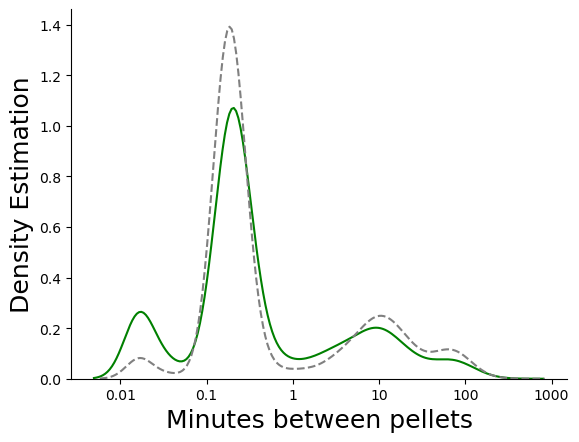

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns



def interpellet_interval_plot(data, ax=[], colors=[], fill=False, labels=[], linestyle="-", **kwargs):
    """
    FED3 Viz: Plot a histogram of interpellet intervals for multiple devices.
    Parameters
    ----------
    FEDs : list of FED3_File objects
        FED3 files (loaded by load.FED3_File)
    kde : bool
        Whether or not to include kernel density estimation, which plots
        probability density (rather than count) and includes a fit line (see
        seaborn.distplot)
    **kwargs :
        ax : matplotlib.axes.Axes
            Axes to plot on, a new Figure and Axes are
            created if not passed
        date_filter : array
            A two-element array of datetimes (start, end) used to filter
            the data
        **kwargs also allows FED3 Viz to pass all settings to all functions.
    Returns
    -------
    fig : matplotlib.figure.Figure
    """

    if ax == []:
        f, ax = plt.subplots()

    if len(colors) != len(data):
        colors = ["grey"] * len(data)
    print(colors)

    if len(labels) != len(data):
        labels = [str(n) for n in range(len(data))]

    for idx, group in enumerate(data):

        y = tp.flatten_list(group)
        y = [np.log10(val*60) for val in y if val > 0]
            
        sns.kdeplot(y, ax=ax,
                    color=colors[idx],
                    fill=fill,
                    label=labels[idx],
                    linestyle=linestyle)

    ax.set_ylabel('Density Estimation',fontsize = 18)
    ax.set_xlabel('Minutes between pellets',fontsize = 18)

    ax.set_xticks(range(-2,4))
    ax.set_xticklabels([10**num for num in range(-2,4)])

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}

IPIs_m_nrpr_gr = get_data_fields(mice, ["grain_ipi"], nrpr_male_selector)
IPIs_m_nrpr_nr = get_data_fields(mice, ["nr_ipi"], nrpr_male_selector)

IPIs_m_prnr_pr = get_data_fields(mice, ["grain_ipi"], prnr_male_selector)
IPIs_m_prnr_nr = get_data_fields(mice, ["grain_ipi"], prnr_male_selector)

f, ax = plt.subplots()

interpellet_interval_plot([IPIs_m_nrpr_gr],
                           colors=["green"],
                           linestyle="-",
                           ax=ax)

interpellet_interval_plot([IPIs_m_nrpr_nr],
                           colors=["grey"],
                           linestyle="--",
                           ax=ax)


6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
['black']


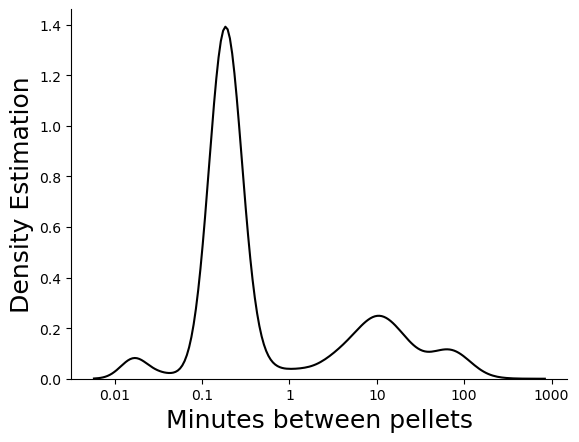

In [5]:
def interpellet_interval_plot(data, ax=[], colors=[], fill=False, labels=[], linestyle="-", **kwargs):
    """
    FED3 Viz: Plot a histogram of interpellet intervals for multiple devices.
    Parameters
    ----------
    FEDs : list of FED3_File objects
        FED3 files (loaded by load.FED3_File)
    kde : bool
        Whether or not to include kernel density estimation, which plots
        probability density (rather than count) and includes a fit line (see
        seaborn.distplot)
    **kwargs :
        ax : matplotlib.axes.Axes
            Axes to plot on, a new Figure and Axes are
            created if not passed
        date_filter : array
            A two-element array of datetimes (start, end) used to filter
            the data
        **kwargs also allows FED3 Viz to pass all settings to all functions.
    Returns
    -------
    fig : matplotlib.figure.Figure
    """

    if ax == []:
        f, ax = plt.subplots()

    if len(colors) != len(data):
        colors = ["grey"] * len(data)
    print(colors)

    if len(labels) != len(data):
        labels = [str(n) for n in range(len(data))]

    for idx, group in enumerate(data):

        y = tp.flatten_list(group)
        y = [np.log10(val*60) for val in y if val > 0]
            
        sns.kdeplot(y, ax=ax,
                    color=colors[idx],
                    fill=fill,
                    label=labels[idx],
                    linestyle=linestyle)

    ax.set_ylabel('Density Estimation',fontsize = 18)
    ax.set_xlabel('Minutes between pellets',fontsize = 18)

    ax.set_xticks(range(-2,4))
    ax.set_xticklabels([10**num for num in range(-2,4)])

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}

IPIs_m_nrpr_gr = get_data_fields(mice, ["grain_ipi"], nrpr_male_selector)
IPIs_m_nrpr_nr = get_data_fields(mice, ["nr_ipi"], nrpr_male_selector)

IPIs_m_prnr_pr = get_data_fields(mice, ["grain_ipi"], prnr_male_selector)
IPIs_m_prnr_nr = get_data_fields(mice, ["grain_ipi"], prnr_male_selector)

f, ax = plt.subplots()

interpellet_interval_plot([IPIs_m_nrpr_nr],
                           colors=["black"],
                           linestyle="-",
                           ax=ax)

# interpellet_interval_plot([IPIs_m_nrpr_nr],
#                            colors=["grey"],
#                            linestyle="--",
#                            ax=ax)


6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
['green']
['grey']


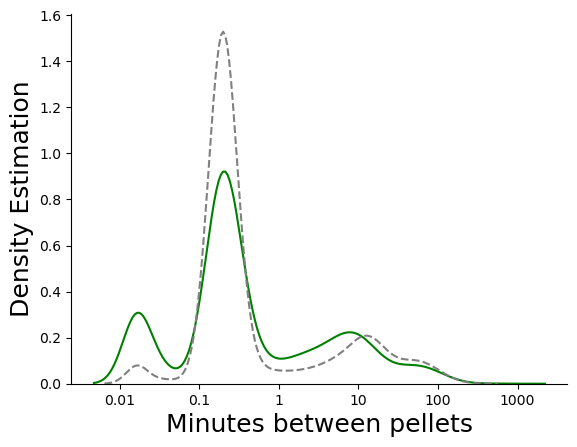

In [6]:
def interpellet_interval_plot(data, ax=[], colors=[], fill=False, labels=[], linestyle="-", **kwargs):
    """
    FED3 Viz: Plot a histogram of interpellet intervals for multiple devices.
    Parameters
    ----------
    FEDs : list of FED3_File objects
        FED3 files (loaded by load.FED3_File)
    kde : bool
        Whether or not to include kernel density estimation, which plots
        probability density (rather than count) and includes a fit line (see
        seaborn.distplot)
    **kwargs :
        ax : matplotlib.axes.Axes
            Axes to plot on, a new Figure and Axes are
            created if not passed
        date_filter : array
            A two-element array of datetimes (start, end) used to filter
            the data
        **kwargs also allows FED3 Viz to pass all settings to all functions.
    Returns
    -------
    fig : matplotlib.figure.Figure
    """

    if ax == []:
        f, ax = plt.subplots()

    if len(colors) != len(data):
        colors = ["grey"] * len(data)
    print(colors)

    if len(labels) != len(data):
        labels = [str(n) for n in range(len(data))]

    for idx, group in enumerate(data):

        y = tp.flatten_list(group)
        y = [np.log10(val*60) for val in y if val > 0]
            
        sns.kdeplot(y, ax=ax,
                    color=colors[idx],
                    fill=fill,
                    label=labels[idx],
                    linestyle=linestyle)

    ax.set_ylabel('Density Estimation',fontsize = 18)
    ax.set_xlabel('Minutes between pellets',fontsize = 18)

    ax.set_xticks(range(-2,4))
    ax.set_xticklabels([10**num for num in range(-2,4)])

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}

IPIs_m_nrpr_gr = get_data_fields(mice, ["grain_ipi"], prnr_male_selector)
IPIs_m_nrpr_nr = get_data_fields(mice, ["nr_ipi"], prnr_male_selector)

IPIs_m_prnr_pr = get_data_fields(mice, ["grain_ipi"], prnr_male_selector)
IPIs_m_prnr_nr = get_data_fields(mice, ["grain_ipi"], prnr_male_selector)

f, ax = plt.subplots()

interpellet_interval_plot([IPIs_m_nrpr_gr],
                           colors=["green"],
                           linestyle="-",
                           ax=ax)

interpellet_interval_plot([IPIs_m_nrpr_nr],
                           colors=["grey"],
                           linestyle="--",
                           ax=ax)


6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
['grey', 'deepskyblue']
['grey', 'deepskyblue']


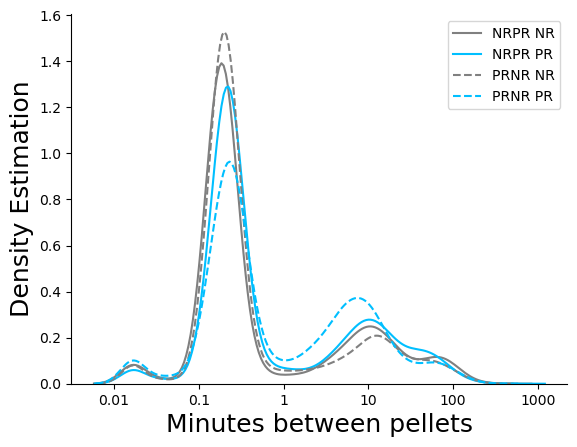

In [9]:
def interpellet_interval_plot(data, ax=[], colors=[], fill=False, labels=[], linestyle="-", **kwargs):
    """
    FED3 Viz: Plot a histogram of interpellet intervals for multiple devices.
    Parameters
    ----------
    FEDs : list of FED3_File objects
        FED3 files (loaded by load.FED3_File)
    kde : bool
        Whether or not to include kernel density estimation, which plots
        probability density (rather than count) and includes a fit line (see
        seaborn.distplot)
    **kwargs :
        ax : matplotlib.axes.Axes
            Axes to plot on, a new Figure and Axes are
            created if not passed
        date_filter : array
            A two-element array of datetimes (start, end) used to filter
            the data
        **kwargs also allows FED3 Viz to pass all settings to all functions.
    Returns
    -------
    fig : matplotlib.figure.Figure
    """

    if ax == []:
        f, ax = plt.subplots()

    if len(colors) != len(data):
        colors = ["grey"] * len(data)
    print(colors)

    if len(labels) != len(data):
        labels = [str(n) for n in range(len(data))]

    for idx, group in enumerate(data):
        y = tp.flatten_list(group)
        y = [np.log10(val * 60) for val in y if val > 0]

        sns.kdeplot(y, ax=ax,
                    color=colors[idx],
                    fill=fill,
                    label=labels[idx],  # Label for legend
                    linestyle=linestyle)

    ax.set_ylabel('Density Estimation', fontsize=18)
    ax.set_xlabel('Minutes between pellets', fontsize=18)

    ax.set_xticks(range(-2, 4))
    ax.set_xticklabels([10**num for num in range(-2, 4)])

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Add the legend
    ax.legend()

nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}

IPIs_m_nrpr_pr = get_data_fields(mice, ["pr_ipi"], nrpr_male_selector)
IPIs_m_nrpr_nr = get_data_fields(mice, ["nr_ipi"], nrpr_male_selector)

IPIs_m_prnr_pr = get_data_fields(mice, ["pr_ipi"], prnr_male_selector)
IPIs_m_prnr_nr = get_data_fields(mice, ["nr_ipi"], prnr_male_selector)

f, ax = plt.subplots()

# First plot with solid lines
interpellet_interval_plot([IPIs_m_nrpr_nr, IPIs_m_nrpr_pr],
                          colors=["grey", "deepskyblue"],
                          linestyle="-",
                          labels=["NRPR NR", "NRPR PR"],  # Add labels for legend
                          ax=ax)

# Second plot with dashed lines
interpellet_interval_plot([IPIs_m_prnr_nr, IPIs_m_prnr_pr],
                          colors=["grey", "deepskyblue"],
                          linestyle="--",
                          labels=["PRNR NR", "PRNR PR"],  # Add labels for legend
                          ax=ax)

plt.show()


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


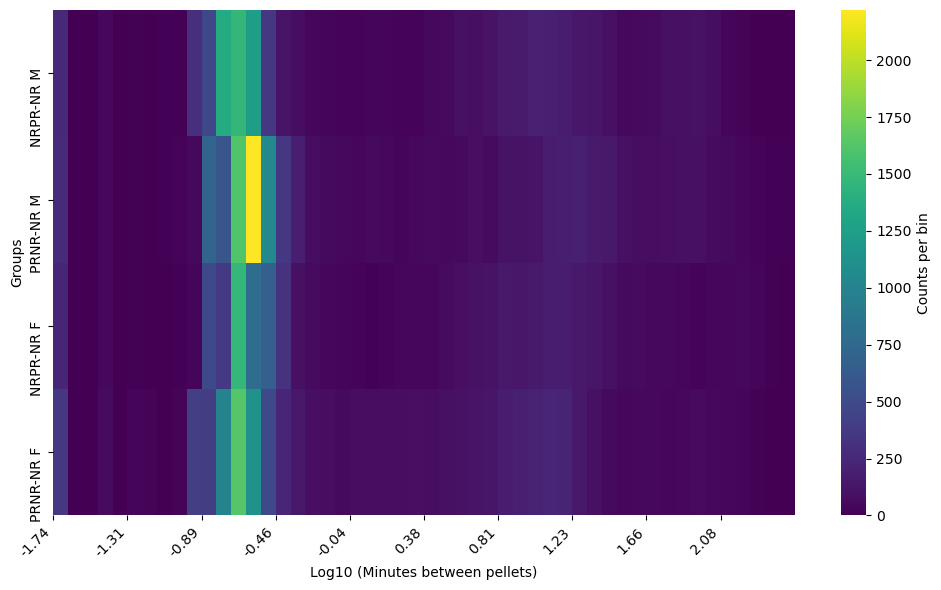

In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def interpellet_interval_heatmap(data1, data2, data3, data4, ax=None, labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], bins=50, tick_step=5, **kwargs):
    """
    FED3 Viz: Create a heatmap of inter-pellet intervals for four groups, with X-axis binned.

    Parameters
    ----------
    data1 : list
        List contains IPI data for group 1 (e.g., NRPR-NR M).
    data2 : list
        List contains IPI data for group 2 (e.g., PRNR-NR M).
    data3 : list
        List contains IPI data for group 3 (e.g., NRPR-NR F).
    data4 : list
        List contains IPI data for group 4 (e.g., PRNR-NR F).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"].
    bins : int, optional
        Number of bins for grouping IPIs on the X-axis, by default 50.
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 5.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """

    if ax is None:
        fig, ax = plt.subplots()

    # Flatten and log-transform the data for all groups
    flattened1 = tp.flatten_list(data1)
    log_transformed1 = [np.log10(val * 60) for val in flattened1 if val > 0]

    flattened2 = tp.flatten_list(data2)
    log_transformed2 = [np.log10(val * 60) for val in flattened2 if val > 0]
    
    flattened3 = tp.flatten_list(data3)
    log_transformed3 = [np.log10(val * 60) for val in flattened3 if val > 0]
    
    flattened4 = tp.flatten_list(data4)
    log_transformed4 = [np.log10(val * 60) for val in flattened4 if val > 0]

    # Bin the data for all groups
    hist1, bin_edges = np.histogram(log_transformed1, bins=bins)
    hist2, _ = np.histogram(log_transformed2, bins=bins)
    hist3, _ = np.histogram(log_transformed3, bins=bins)
    hist4, _ = np.histogram(log_transformed4, bins=bins)

    # Create a 2D array from the histogram data, stacking the four groups
    data_matrix = np.array([hist1, hist2, hist3, hist4])

    # Create the heatmap
    sns.heatmap(data_matrix, ax=ax, cmap="viridis", cbar_kws={'label': 'Counts per bin'}, **kwargs)

    # Set labels
    ax.set_yticks([0.5, 1.5, 2.5, 3.5])
    ax.set_yticklabels(labels)
    ax.set_xlabel('Log10 (Minutes between pellets)')
    ax.set_ylabel('Groups')

    # Set X-axis labels as bin centers
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Only show every nth tick to avoid label overlap
    ax.set_xticks(np.arange(0, len(bin_centers), tick_step))
    ax.set_xticklabels([f"{center:.2f}" for center in bin_centers[::tick_step]], rotation=45, ha='right')

    # Adjust the plot to prevent label overlapping
    plt.tight_layout()

    return ax

# Fetching the data for the four groups
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"}

IPIs_m_nrpr_nr = get_data_fields(mice, ["nr_ipi"], nrpr_male_selector)
IPIs_m_prnr_nr = get_data_fields(mice, ["nr_ipi"], prnr_male_selector)
IPIs_f_nrpr_nr = get_data_fields(mice, ["nr_ipi"], nrpr_female_selector)
IPIs_f_prnr_nr = get_data_fields(mice, ["nr_ipi"], prnr_female_selector)

# Plotting the heatmap with all four groups on the same plot
fig, ax = plt.subplots(figsize=(10, 6))

interpellet_interval_heatmap(IPIs_m_nrpr_nr, IPIs_m_prnr_nr, IPIs_f_nrpr_nr, IPIs_f_prnr_nr, ax=ax, 
                             labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], 
                             bins=50, tick_step=5)

plt.show()







What Happens in the cell above:
Histogram Bin Count: The heatmap is based on the distribution of inter-pellet intervals (IPI), which means you're taking the time between pellets for each mouse, transforming the data (log-transform), and then binning the data into groups (bins). Each bin represents a range of values for the log-transformed IPI data.

One Line Per Group: Since you're creating histograms (one for each group), the heatmap will have one row for each group. Each row represents the distribution of IPIs for that group across the binned log-transformed values (i.e., the counts of IPIs falling into each bin). The X-axis shows the log-transformed time between pellets, while the Y-axis represents different groups.

For example, the histogram might show how many IPIs for each group fall into a range like "log10(0.5-1 minute)" or "log10(2-3 minutes)." This results in one long line per group because we're looking at the distribution across time intervals, not the time-series data itself.
Binning: The X-axis bins represent time intervals (in minutes between pellets) that are log-transformed. You're showing how many IPIs fall into each time bin for each group.

Why the heatmap shows one long line per group:
In this heatmap, each voxel (cell) represents how many inter-pellet intervals (IPIs) fall into a particular bin (a time range) for each group.
Since you're binning the data, and each bin represents a specific range of time intervals, there’s only one row per group because you're visualizing the distribution of IPIs, not the raw IPI data across time.
The Y-axis corresponds to groups, and the X-axis corresponds to log10 of the IPI bins (interval between pellets).
Comparison to the Previous Heatmaps:
In your hourly meals heatmaps, each row represented a mouse's feeding behavior across hours, and multiple rows per group were shown.
In this IPI heatmap, you’re dealing with a distribution of intervals, so you have only one row per group because you are summarizing how many IPIs fall into each time bin, rather than plotting the data across hours/days.
To Summarize:
Each row in the current heatmap corresponds to a group (like "NRPR-NR M") and represents the frequency distribution of inter-pellet intervals (IPI) in log10 minutes.
Each cell in a row shows the number of intervals (IPIs) that fall into a specific time bin for that group.
Therefore, the heatmap has only one row per group because the data is summarized as a distribution across bins (time intervals), not as a time series.

# Code below , measuring the peak/max density for each group based on their ipi

6 items in output dictionary


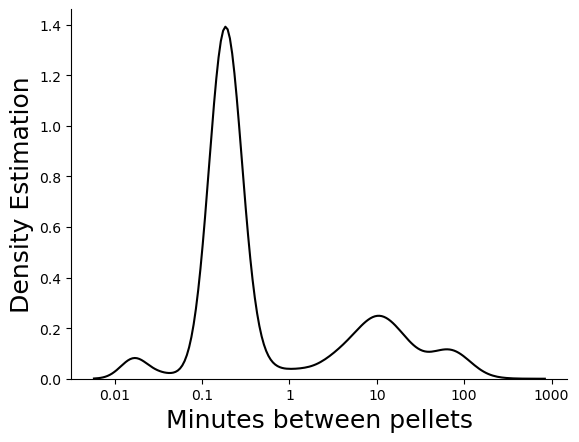

Peak log10(minutes) between pellets: -0.7336397395636982
Peak density: 1.3918186685518692


In [27]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def interpellet_interval_plot(data, ax=[], colors=[], fill=False, labels=[], linestyle="-", **kwargs):
    """
    FED3 Viz: Plot a histogram of interpellet intervals for multiple devices.
    Additionally, calculates and returns the peak (maximum) of the density curve for the first group.
    """
    
    if ax == []:
        f, ax = plt.subplots()

    if len(colors) != len(data):
        colors = ["grey"] * len(data)
    
    if len(labels) != len(data):
        labels = [str(n) for n in range(len(data))]

    peak_x, peak_y = None, None  # Initialize variables for peak
    
    for idx, group in enumerate(data):
        y = tp.flatten_list(group)
        y = [np.log10(val * 60) for val in y if val > 0]  # Convert IPIs to log10 of minutes
        
        # Create KDE plot and capture the line data
        kde = sns.kdeplot(y, ax=ax,
                          color=colors[idx],
                          fill=fill,
                          label=labels[idx],
                          linestyle=linestyle)
        
        # For the first group (IPIs_m_nrpr_nr), extract the line data and find the peak
        if idx == 0:  # Assuming you want the peak for the first group
            line = kde.get_lines()[-1]  # Get the most recent line added
            x_data = line.get_xdata()   # X-axis data (log-transformed time)
            y_data = line.get_ydata()   # Y-axis data (density values)
            
            # Find the peak (x-value where y is maximum)
            peak_idx = np.argmax(y_data)
            peak_x = x_data[peak_idx]  # The x-value (log10 of minutes between pellets) at the peak
            peak_y = y_data[peak_idx]  # The y-value (density) at the peak

    ax.set_ylabel('Density Estimation', fontsize=18)
    ax.set_xlabel('Minutes between pellets', fontsize=18)

    ax.set_xticks(range(-2, 4))
    ax.set_xticklabels([10**num for num in range(-2, 4)])

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    return peak_x, peak_y  # Return the peak value (log-transformed x and density y)

# Example usage for IPIs_m_nrpr_nr group:
nrpr_male_selector = {"order": 1, "sex": "M"}
IPIs_m_nrpr_nr = get_data_fields(mice, ["nr_ipi"], nrpr_male_selector)

f, ax = plt.subplots()

# Get the peak of the inter-pellet intervals (IPI) for the first group (IPIs_m_nrpr_nr)
peak_x, peak_y = interpellet_interval_plot([IPIs_m_nrpr_nr],
                                           colors=["black"],
                                           linestyle="-",
                                           ax=ax)

plt.show()

# Output the peak values
print(f"Peak log10(minutes) between pellets: {peak_x}")
print(f"Peak density: {peak_y}")


The output you obtained:

- **Peak log10(minutes) between pellets**: `-0.7336`
- **Peak density**: `1.3918`

### Interpretation:

1. **Peak log10(minutes)**:  the **most frequent inter-pellet interval** for the **NRPR NR group** is around **11.16 seconds**.

2. **Peak density**: The density value of `1.3918` indicates how **frequently** this interval occurs relative to others. A higher density suggests that a large proportion of pellet-taking events are occurring around this 11.16-second interval.

### Conclusion:
The peak value shows that for the **NRPR NR group**, the most common interval between pellets is approximately **11.16 seconds**, and this interval occurs more frequently than other intervals (as indicated by the peak density). This suggests that, in the **non-restricted (NR) phase**, mice are taking pellets in bursts with relatively short pauses between them.



FOR PRNR MALEs on PR diet

- **Peak log10(minutes) between pellets**: `-0.638`
- **Peak density**: `0.9642`

### Interpretation:

1. **Peak log10(minutes)**:  **most frequent inter-pellet interval** in this case is about **13.86 seconds**.

2. **Peak density**: The density value of `0.9642` is lower than the previous peak density of `1.3918`, suggesting that this interval is **less frequent** compared to the earlier group (which had a peak density of 1.3918 at around 11.16 seconds).

### Comparison to the Previous Output:
- **Interval length**: The **inter-pellet interval** is slightly longer here (around **13.86 seconds**) compared to the earlier value of **11.16 seconds**.
- **Density**: The density of **0.9642** suggests that pellet-taking behavior is more **spread out** in this case, with less clustering around the most frequent interval (13.86 seconds) compared to the earlier group, which had more consistent pellet intake at 11.16 seconds.

### Possible Explanation:
This shift could indicate that mice in this condition are taking pellets less frequently and with more variability between pellets. The longer interval and lower density may suggest that **fewer pellets are being consumed in quick succession**, or that pellet intake is less consistent compared to the other group.


# Key Terms of above KDE plot:
Log-transformed IPI (x-value): The time interval between two consecutive pellets in log10(min). This gives you the time between two pellets in a logarithmic scale.
Density (y-value): The density of events at that specific IPI (how often that time interval occurs compared to others).

# how does it fit to our meal frequency finding? where PR mice on PR diet take meals more frequently:


Inter-pellet interval (IPI) and meal frequency:
The IPI measures the time between individual pellets, not entire meals. Even though the PR diet leads to more frequent meals, the longer inter-pellet intervals in PR groups could indicate that meals are composed of slightly fewer pellets, but the intervals between individual pellets within those meals are longer than in NR.
In contrast, NR mice may consume more pellets quickly within each meal, resulting in shorter IPIs.


Meal frequency vs. pellet frequency:

More frequent meals on the PR diet doesn't necessarily mean shorter IPIs. Instead, mice on PR might take more frequent but smaller meals (with slightly longer intervals between individual pellets). This could lead to an overall increase in meal frequency while maintaining slightly longer IPIs.


Density difference:

The lower density in the PR groups suggests that pellet consumption is more variable on the PR diet. In other words, mice on the PR diet might not follow as consistent a pattern of pellet intake as those on the NR diet, possibly because they’re taking more frequent but smaller, less regular meals.

6 items in output dictionary


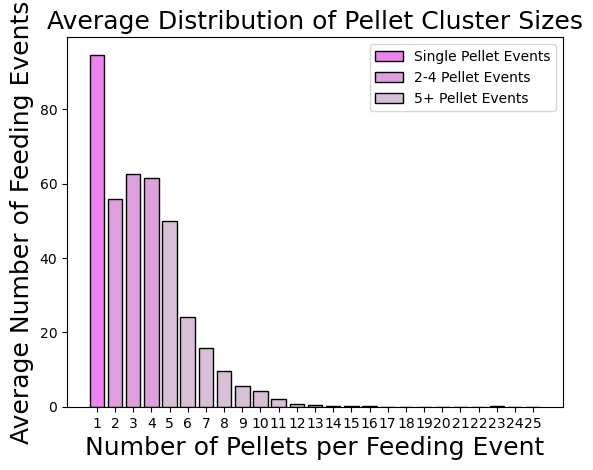

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def flatten_list(nested_list):
    """Helper function to flatten a list of lists into a single list."""
    return [item for sublist in nested_list for item in sublist]

def cluster_pellets_by_ipi(pellettimes, ipi_threshold=60):
    """
    Cluster pellet events based on inter-pellet interval (IPI).
    Parameters
    ----------
    pellettimes : list of timestamps (in seconds)
        Times when each pellet was taken.
    ipi_threshold : float
        Threshold for defining clusters based on IPI (in seconds). Default is 60 seconds.
    
    Returns
    -------
    clusters : list of lists
        Each sublist contains the timestamps of pellets within a cluster.
    """
    pellettimes = np.array(sorted(pellettimes)) * 3600  # Convert from hours to seconds and sort

    IPIs = np.diff(pellettimes)  # Calculate time differences between consecutive pellets

    # Initialize clusters
    clusters = []
    current_cluster = [pellettimes[0]]  # Start with the first pellet

    for i, ipi in enumerate(IPIs):
        if ipi <= ipi_threshold:
            current_cluster.append(pellettimes[i + 1])
        else:
            clusters.append(current_cluster)
            current_cluster = [pellettimes[i + 1]]

    if current_cluster:
        clusters.append(current_cluster)

    return clusters

def get_cluster_size_distribution_for_mouse(pellettimes):
    """
    Get the cluster size distribution for a single mouse.
    Parameters
    ----------
    pellettimes : list of timestamps (in seconds)
        Times when each pellet was taken.
    
    Returns
    -------
    cluster_sizes : list
        The number of pellets in each cluster for this mouse.
    """
    clusters = cluster_pellets_by_ipi(pellettimes)
    cluster_sizes = [len(cluster) for cluster in clusters]
    return cluster_sizes

def average_cluster_sizes_across_mice(pellettimes_group, max_pellets_per_event=10):
    """
    Calculate the average cluster size distribution across multiple mice.
    Parameters
    ----------
    pellettimes_group : list of lists
        A list of timestamp lists for each mouse.
    max_pellets_per_event : int
        The maximum number of pellets per event to include in the analysis.
    
    Returns
    -------
    avg_cluster_sizes : list
        The average number of events for each cluster size (1 pellet, 2 pellets, etc.).
    """
    # Initialize the counts for each pellet size
    total_cluster_counts = np.zeros(max_pellets_per_event)

    # Loop over each mouse and calculate cluster size distribution
    for pellettimes in pellettimes_group:
        cluster_sizes = get_cluster_size_distribution_for_mouse(pellettimes)
        for size in cluster_sizes:
            if size <= max_pellets_per_event:
                total_cluster_counts[size - 1] += 1
            else:
                # If size exceeds max_pellets_per_event, add to the last bin
                total_cluster_counts[-1] += 1

    # Calculate the average cluster size distribution across mice
    avg_cluster_sizes = total_cluster_counts / len(pellettimes_group)
    
    return avg_cluster_sizes

def plot_average_cluster_size_distribution(avg_cluster_sizes, max_pellets_per_event=25):
    """
    Plot the average cluster size distribution across multiple mice with custom colors.
    Parameters
    ----------
    avg_cluster_sizes : list
        The average number of events for each cluster size (1 pellet, 2 pellets, etc.).
    max_pellets_per_event : int
        The maximum number of pellets per event included in the analysis.
    """
    f, ax = plt.subplots()

    bins = np.arange(1, max_pellets_per_event + 1)

    # Define colors based on cluster sizes
    colors = []
    for size in bins:
        if size == 1:
            colors.append('violet')  # 1-pellet events
        elif 2 <= size <= 4:
            colors.append('plum')   # 2-4-pellet events
        else:
            colors.append('thistle') # 5+ pellet events

    # Plot the bar chart with custom colors
    ax.bar(bins, avg_cluster_sizes, color=colors, edgecolor='black')

    ax.set_ylabel('Average Number of Feeding Events', fontsize=18)
    ax.set_xlabel('Number of Pellets per Feeding Event', fontsize=18)
    ax.set_xticks(bins)
    ax.set_title('Average Distribution of Pellet Cluster Sizes', fontsize=18)

    # Add legend to explain the colors
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='violet', edgecolor='black', label='Single Pellet Events'),
                       Patch(facecolor='plum', edgecolor='black', label='2-4 Pellet Events'),
                       Patch(facecolor='thistle', edgecolor='black', label='5+ Pellet Events')]
    ax.legend(handles=legend_elements)

    ax.grid(False)
    plt.show()

nrpr_male_selector = {"order": 1, "sex": "M"}
pellettimes_group = get_data_fields(mice, ["nr_timestamps"], nrpr_male_selector)  # Get the timestamps for each mouse

# Calculate the average cluster size distribution across mice
avg_cluster_sizes = average_cluster_sizes_across_mice(pellettimes_group, max_pellets_per_event=25)

# Plot the average distribution of cluster sizes with custom colors
plot_average_cluster_size_distribution(avg_cluster_sizes, max_pellets_per_event=25)


5 items in output dictionary


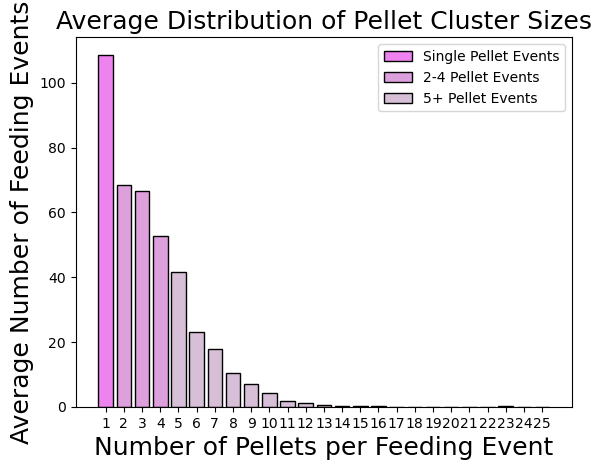

In [6]:

nrpr_female_selector = {"order": 1, "sex": "F"}
pellettimes_group_female = get_data_fields(mice, ["nr_timestamps"], nrpr_female_selector)  # Get timestamps for females

combined_pellettimes_group = pellettimes_group + pellettimes_group_female

combined_avg_cluster_sizes = average_cluster_sizes_across_mice(combined_pellettimes_group, max_pellets_per_event=25)

# Step 4: Plot the combined data
plot_average_cluster_size_distribution(combined_avg_cluster_sizes, max_pellets_per_event=25)


In [13]:
import pandas as pd  # Import pandas to handle DataFrame operations

# Function to save data as CSV
def save_cluster_data_to_csv(pellettimes_group, pellettimes_group_female, max_pellets_per_event=25, output_csv="../results/combined_cluster_sizes.csv"):
    """
    Save the cluster size distribution data for both male and female mice into a CSV file.
    
    Parameters
    ----------
    pellettimes_group : list of lists
        List of timestamp lists for male mice.
    pellettimes_group_female : list of lists
        List of timestamp lists for female mice.
    max_pellets_per_event : int
        Maximum number of pellets per event to include in the analysis.
    output_csv : str
        The output CSV file path.
    
    Returns
    -------
    None
    """
    combined_pellettimes_group = pellettimes_group + pellettimes_group_female  # Combine male and female timestamp data
    
    # Initialize a list to store data for each mouse
    data_per_mouse = []

    # Process each mouse individually
    for i, pellettimes in enumerate(combined_pellettimes_group):
        # Calculate cluster size counts for each mouse
        cluster_sizes = get_cluster_size_distribution_for_mouse(pellettimes)  # Removed max_pellets_per_event argument

        # Prepare the data row for this mouse
        mouse_data = {"MouseID": f"Mouse_{i+1}"}
        
        # Add counts for each cluster size (1 pellet, 2 pellets, etc.)
        for size in range(1, max_pellets_per_event + 1):
            mouse_data[f"Count_{size}"] = cluster_sizes.count(size)
        
        data_per_mouse.append(mouse_data)
    
    # Create a DataFrame from the data
    df = pd.DataFrame(data_per_mouse)

    # Save the DataFrame to a CSV file
    df.to_csv(output_csv, index=False)
    print(f"Data saved to {output_csv}")

    # Display the DataFrame
    print(df)

# Example Usage
output_csv = "../results/combined_cluster_sizes.csv"  # Define the path to save the CSV

# Save the combined cluster size data for male and female mice to a CSV file
save_cluster_data_to_csv(pellettimes_group, pellettimes_group_female, max_pellets_per_event=25, output_csv=output_csv)


Data saved to ../results/combined_cluster_sizes.csv
     MouseID  Count_1  Count_2  Count_3  Count_4  Count_5  Count_6  Count_7  \
0    Mouse_1       45       31       48       67       58       30       18   
1    Mouse_2       86       61       59       56       28       17       18   
2    Mouse_3       62       33       80       58       57       25       13   
3    Mouse_4       68       47       61       70       62       28       19   
4    Mouse_5      163       89       55       49       42       20       14   
5    Mouse_6      144       74       73       69       52       25       12   
6    Mouse_7       75       58       65       57       48       27       30   
7    Mouse_8       28       15       33       45       39       30       25   
8    Mouse_9      209      143      147       43       27        8       12   
9   Mouse_10      296      177       78       38       16       12        9   
10  Mouse_11       19       24       34       28       29       30       27   


# Cell below , revising the plots  , first we plot ipi kde of nr_timestamps combined data of male and female in order 1 and 2 and we measure peak of the distribution  , Second the same process for pr_timestamps

6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
5 items in output dictionary


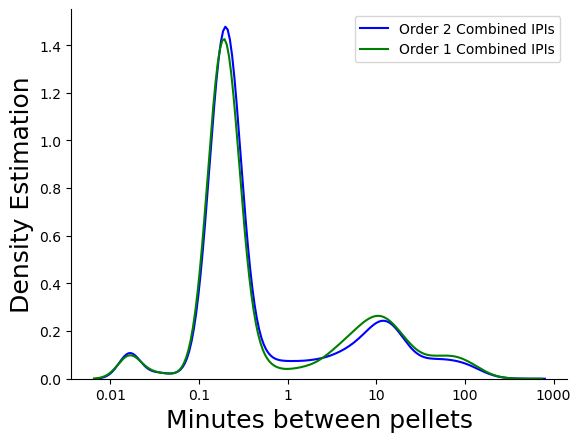

Order 2 Peak log10(minutes): -0.7011992052135982
Order 2 Peak density: 1.477277520045551
Order 1 Peak log10(minutes): -0.7107846788471681
Order 1 Peak density: 1.4252999448193437


In [10]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def interpellet_interval_plot(data, ax=[], colors=[], fill=False, labels=[],  linestyle="-", **kwargs):
    """
    FED3 Viz: Plot a histogram of interpellet intervals for multiple devices.
    Additionally, calculates and returns the peak (maximum) of the density curve for the first group.
    """
    
    if ax == []:
        f, ax = plt.subplots()

    if len(colors) != len(data):
        colors = ["grey"] * len(data)
    
    if len(labels) != len(data):
        labels = [str(n) for n in range(len(data))]

    peak_x, peak_y = [], []  # Initialize variables for peak
    
    for idx, group in enumerate(data):
        y = tp.flatten_list(group)
        y = [np.log10(val * 60) for val in y if val > 0]  # Convert IPIs to log10 of minutes
        
        # Create KDE plot and capture the line data
        kde = sns.kdeplot(y, ax=ax,
                          color=colors[idx],
                          fill=fill,
                          label=labels[idx],
                          linestyle=linestyle)
        
        # Extract the line data and find the peak for each group
        line = kde.get_lines()[-1]  # Get the most recent line added
        x_data = line.get_xdata()   # X-axis data (log-transformed time)
        y_data = line.get_ydata()   # Y-axis data (density values)
        
        # Find the peak (x-value where y is maximum)
        peak_idx = np.argmax(y_data)
        peak_x.append(x_data[peak_idx])  # The x-value (log10 of minutes between pellets) at the peak
        peak_y.append(y_data[peak_idx])  # The y-value (density) at the peak

    ax.set_ylabel('Density Estimation', fontsize=18)
    ax.set_xlabel('Minutes between pellets', fontsize=18)

    ax.set_xticks(range(-2, 4))
    ax.set_xticklabels([10**num for num in range(-2, 4)])

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    return peak_x, peak_y  # Return the peak value (log-transformed x and density y)

# Step 1: Get IPI data for Order 2 males
nrpr_male_selector_order2 = {"order": 2, "sex": "M"}
IPIs_m_nrpr_order2 = get_data_fields(mice, ["nr_ipi"], nrpr_male_selector_order2)

# Step 2: Get IPI data for Order 2 females
nrpr_female_selector_order2 = {"order": 2, "sex": "F"}
IPIs_f_nrpr_order2 = get_data_fields(mice, ["nr_ipi"], nrpr_female_selector_order2)

# Step 3: Combine the IPI data from both males and females for Order 2
combined_IPIs_order2 = IPIs_m_nrpr_order2 + IPIs_f_nrpr_order2

# Step 4: Get IPI data for Order 1 males
nrpr_male_selector_order1 = {"order": 1, "sex": "M"}
IPIs_m_nrpr_order1 = get_data_fields(mice, ["nr_ipi"], nrpr_male_selector_order1)

# Step 5: Get IPI data for Order 1 females
nrpr_female_selector_order1 = {"order": 1, "sex": "F"}
IPIs_f_nrpr_order1 = get_data_fields(mice, ["nr_ipi"], nrpr_female_selector_order1)

# Step 6: Combine the IPI data from both males and females for Order 1
combined_IPIs_order1 = IPIs_m_nrpr_order1 + IPIs_f_nrpr_order1

# Step 7: Plot both Order 1 and Order 2 combined data and get the peaks
f, ax = plt.subplots()

peak_x, peak_y = interpellet_interval_plot([combined_IPIs_order2, combined_IPIs_order1],
                                           colors=["blue", "green"],
                                           labels=["Order 2 Combined IPIs", "Order 1 Combined IPIs"],
                                           linestyle="-",
                                           ax=ax)

# Show the plot
plt.legend()
plt.show()

# Output the peak values (log10 of minutes between pellets and density)
print(f"Order 2 Peak log10(minutes): {peak_x[0]}")
print(f"Order 2 Peak density: {peak_y[0]}")
print(f"Order 1 Peak log10(minutes): {peak_x[1]}")
print(f"Order 1 Peak density: {peak_y[1]}")


Here's the interpretation of the peak values for Order 2 and Order 1 based on the inter-pellet intervals (IPI) in the **NR phase**:

### **Order 2 Peak log10(minutes): -0.701**
- **Log10(minutes)**: The peak IPI for Order 2 is at **-0.701** in log10 of minutes.
- **Converted to minutes**: the most common time interval between two consecutive pellets for mice in Order 2 is about **12 seconds**.

- **Peak Density: 1.477**: The density at this peak indicates how concentrated the IPIs are around the 12-second mark. A density of **1.477** means there is a high concentration of pellet retrievals at this interval, indicating that the majority of pellet retrievals by Order 2 mice occur around this time.

---

### **Order 1 Peak log10(minutes): -0.711**
- **Log10(minutes)**: The peak IPI for Order 1 is at **-0.711** in log10 of minutes.
- **Converted to minutes**: most frequent time interval between consecutive pellet retrievals for Order 1 mice is about **11.7 seconds**.

- **Peak Density: 1.425**: The density at this peak is **1.425**, which is slightly lower than that of Order 2. This suggests that although the most common IPI in Order 1 is around 11.7 seconds, the concentration of pellet retrievals at this interval is marginally less dense compared to Order 2.

---


- Both **Order 1** and **Order 2** have similar peak intervals between pellets, around **12 seconds** (slightly lower for Order 1 at 11.7 seconds).
- **Order 2** shows a slightly higher density at the peak (**1.477** vs. **1.425**), suggesting that pellet retrievals in Order 2 are slightly more concentrated around the 12-second interval than in Order 1. This could imply that Order 2 mice exhibit a more consistent feeding pattern with respect to their IPI than Order 1 mice.

Overall, the feeding behavior in terms of IPI is very similar between the two orders, with minor differences in consistency.

6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
5 items in output dictionary


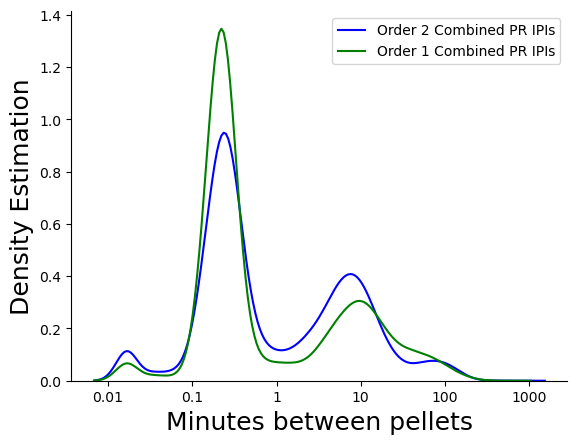

Order 2 PR Phase Peak log10(minutes): -0.6277819397048472
Order 2 PR Phase Peak density: 0.9490423998850805
Order 1 PR Phase Peak log10(minutes): -0.6551335413822412
Order 1 PR Phase Peak density: 1.347182619888186


In [11]:
# Step 1: Get IPI data for Order 2 males in PR phase
pr_male_selector_order2 = {"order": 2, "sex": "M"}
IPIs_m_pr_order2 = get_data_fields(mice, ["pr_ipi"], pr_male_selector_order2)

# Step 2: Get IPI data for Order 2 females in PR phase
pr_female_selector_order2 = {"order": 2, "sex": "F"}
IPIs_f_pr_order2 = get_data_fields(mice, ["pr_ipi"], pr_female_selector_order2)

# Step 3: Combine the IPI data from both males and females for Order 2 in PR phase
combined_IPIs_pr_order2 = IPIs_m_pr_order2 + IPIs_f_pr_order2

# Step 4: Get IPI data for Order 1 males in PR phase
pr_male_selector_order1 = {"order": 1, "sex": "M"}
IPIs_m_pr_order1 = get_data_fields(mice, ["pr_ipi"], pr_male_selector_order1)

# Step 5: Get IPI data for Order 1 females in PR phase
pr_female_selector_order1 = {"order": 1, "sex": "F"}
IPIs_f_pr_order1 = get_data_fields(mice, ["pr_ipi"], pr_female_selector_order1)

# Step 6: Combine the IPI data from both males and females for Order 1 in PR phase
combined_IPIs_pr_order1 = IPIs_m_pr_order1 + IPIs_f_pr_order1

# Step 7: Plot both Order 1 and Order 2 combined PR phase data and get the peaks
f, ax = plt.subplots()

peak_x_pr, peak_y_pr = interpellet_interval_plot([combined_IPIs_pr_order2, combined_IPIs_pr_order1],
                                                 colors=["blue", "green"],
                                                 labels=["Order 2 Combined PR IPIs", "Order 1 Combined PR IPIs"],
                                                 linestyle="-",
                                                 ax=ax)

# Show the plot
plt.legend()
plt.show()

# Output the peak values for PR phase (log10 of minutes between pellets and density)
print(f"Order 2 PR Phase Peak log10(minutes): {peak_x_pr[0]}")
print(f"Order 2 PR Phase Peak density: {peak_y_pr[0]}")
print(f"Order 1 PR Phase Peak log10(minutes): {peak_x_pr[1]}")
print(f"Order 1 PR Phase Peak density: {peak_y_pr[1]}")



### **Order 2 PR Phase Peak log10(minutes): -0.628**
- **Log10(minutes)**: The peak IPI for Order 2 in the PR phase is at **-0.628** in log10 of minutes.
- **Converted to minutes**: the most frequent time interval between consecutive pellets for Order 2 mice in the PR phase is around **14.2 seconds**.

- **Peak Density: 0.949**: The density at this peak is **0.949**, which is lower compared to the NR phase. This lower density suggests that the pellet retrievals are more spread out in the PR phase for Order 2 mice, indicating a less consistent or less frequent pattern of pellet retrievals compared to the NR phase.

---

### **Order 1 PR Phase Peak log10(minutes): -0.655**
- **Log10(minutes)**: The peak IPI for Order 1 in the PR phase is at **-0.655** in log10 of minutes.
- **Converted to minutes**: the most common IPI for Order 1 mice in the PR phase is about **13.3 seconds**, which is slightly shorter than that of Order 2.

- **Peak Density: 1.347**: The density at the peak is **1.347**, which is higher than for Order 2. This indicates that Order 1 mice have a more consistent pattern of pellet retrievals at this interval, suggesting more frequent pellet retrieval behavior clustered around the **13.3-second** interval in the PR phase.

---


- **Order 2** mice in the PR phase have a peak IPI of around **14.2 seconds**, while **Order 1** mice have a peak at **13.3 seconds**. Both peaks are slightly longer than in the NR phase (where IPIs were around 12 seconds), indicating that mice tend to space out their pellet retrievals more in the PR phase.
- **Order 1** shows a much higher density (**1.347**) at the peak compared to Order 2 (**0.949**), suggesting that Order 1 mice exhibit more frequent and consistent feeding behavior at the 13.3-second interval, while Order 2 mice have a more spread-out, less concentrated pattern of pellet retrievals at 14.2 seconds.
- The difference in density suggests that **Order 1 mice** maintain a more stable feeding rhythm in the PR phase compared to **Order 2 mice**, which might indicate differences in how the two orders respond to protein restriction.


- Both orders show longer intervals between pellet retrievals in the PR phase compared to the NR phase (around 13-14 seconds vs. 12 seconds).
- Order 1 mice are more consistent in their pellet retrieval behavior in the PR phase, while Order 2 mice are more variable, with a lower peak density around the 14-second mark.

6 items in output dictionary
5 items in output dictionary
6 items in output dictionary
6 items in output dictionary


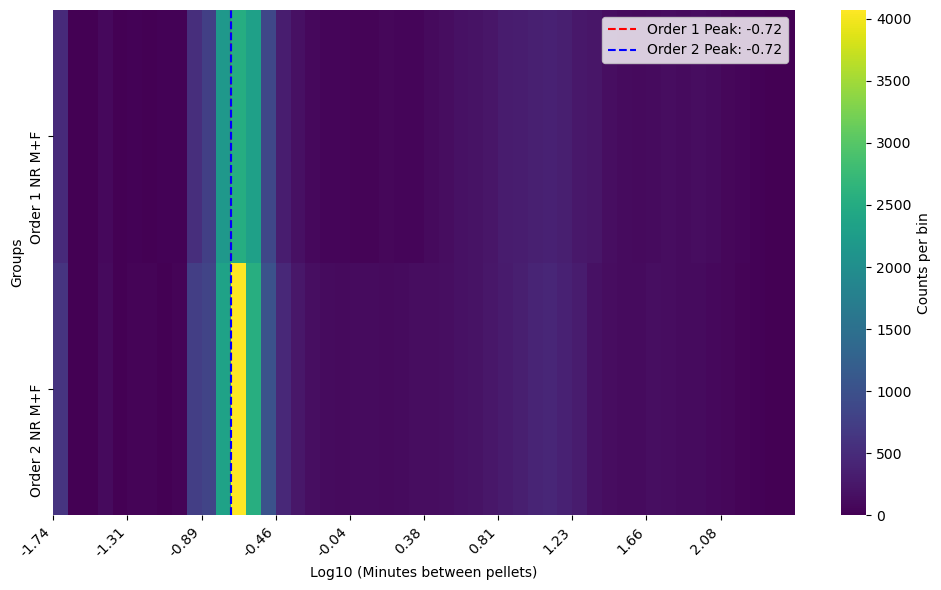

Order 1 NR Phase Most Significant Log10(minutes): -0.7178082178554399
Order 2 NR Phase Most Significant Log10(minutes): -0.7178082178554399


In [133]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def interpellet_interval_heatmap(data1, data2, ax=None, labels=["Order 1 NR M+F", "Order 2 NR M+F"], bins=50, tick_step=5, **kwargs):
    """
    Create a heatmap of inter-pellet intervals for two groups, with X-axis binned.
    Additionally, highlight the most significant bin (the bin with the highest count).
    """

    if ax is None:
        fig, ax = plt.subplots()

    # Flatten and log-transform the data for both groups
    flattened1 = tp.flatten_list(data1)
    log_transformed1 = [np.log10(val * 60) for val in flattened1 if val > 0]

    flattened2 = tp.flatten_list(data2)
    log_transformed2 = [np.log10(val * 60) for val in flattened2 if val > 0]

    # Bin the data for both groups
    hist1, bin_edges = np.histogram(log_transformed1, bins=bins)
    hist2, _ = np.histogram(log_transformed2, bins=bins)

    # Create a 2D array from the histogram data, stacking the two groups
    data_matrix = np.array([hist1, hist2])

    # Create the heatmap
    sns.heatmap(data_matrix, ax=ax, cmap="viridis", cbar_kws={'label': 'Counts per bin'}, **kwargs)

    # Set labels
    ax.set_yticks([0.5, 1.5])
    ax.set_yticklabels(labels)
    ax.set_xlabel('Log10 (Minutes between pellets)')
    ax.set_ylabel('Groups')

    # Set X-axis labels as bin centers
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Only show every nth tick to avoid label overlap
    ax.set_xticks(np.arange(0, len(bin_centers), tick_step))
    ax.set_xticklabels([f"{center:.2f}" for center in bin_centers[::tick_step]], rotation=45, ha='right')

    # Adjust the plot to prevent label overlapping
    plt.tight_layout()

    # Find the most significant bin (bin with the maximum count) for each group
    peak_bin_order1 = np.argmax(hist1)
    peak_bin_order2 = np.argmax(hist2)

    # Highlight the most significant bin by adding vertical lines
    ax.axvline(peak_bin_order1, color='red', linestyle='--', label=f"Order 1 Peak: {bin_centers[peak_bin_order1]:.2f}")
    ax.axvline(peak_bin_order2, color='blue', linestyle='--', label=f"Order 2 Peak: {bin_centers[peak_bin_order2]:.2f}")

    plt.legend()

    # Return the most significant bin (log10 of minutes)
    return ax, bin_centers[peak_bin_order1], bin_centers[peak_bin_order2]

# Fetching the data for NR phase for both orders
nr_male_order1 = get_data_fields(mice, ["nr_ipi"], {"order": 1, "sex": "M"})
nr_female_order1 = get_data_fields(mice, ["nr_ipi"], {"order": 1, "sex": "F"})
combined_nr_order1 = nr_male_order1 + nr_female_order1

nr_male_order2 = get_data_fields(mice, ["nr_ipi"], {"order": 2, "sex": "M"})
nr_female_order2 = get_data_fields(mice, ["nr_ipi"], {"order": 2, "sex": "F"})
combined_nr_order2 = nr_male_order2 + nr_female_order2

# Plotting NR phase heatmap and identifying the most significant bin
fig, ax = plt.subplots(figsize=(10, 6))

ax, peak_log10_order1, peak_log10_order2 = interpellet_interval_heatmap(combined_nr_order1, combined_nr_order2, ax=ax, 
                                       labels=["Order 1 NR M+F", "Order 2 NR M+F"], 
                                       bins=50, tick_step=5)

plt.show()

# Output the most significant bin (log10 of minutes) for each group
print(f"Order 1 NR Phase Most Significant Log10(minutes): {peak_log10_order1}")
print(f"Order 2 NR Phase Most Significant Log10(minutes): {peak_log10_order2}")




### **Order 1 NR Phase Most Significant Log10(minutes): -0.718**
- **Log10(minutes)**: The value **-0.718** is the log10 of the most frequent time interval (inter-pellet interval, or IPI) in minutes.
- **Converting to real minutes**:in **Order 1** during the **NR phase**, the most frequent interval between pellets (the "hottest" bin in the heatmap) is around **11.5 seconds**.

### **Order 2 NR Phase Most Significant Log10(minutes): -0.718**
- **Log10(minutes)**: This value is exactly the same as for Order 1, which means that the most frequent inter-pellet interval in **Order 2** during the **NR phase** is also around **11.5 seconds**.

### **Summary**:
- For **both Order 1 and Order 2** in the **NR phase**, the most significant inter-pellet interval (the bin with the highest count in the heatmap) occurs at approximately **11.5 seconds**.
- This indicates that both groups of mice show a very similar feeding pattern in the NR phase, with the majority of their pellet retrievals happening around 11.5 seconds apart.

This suggests that, in the NR phase, both Order 1 and Order 2 mice are exhibiting similar feeding behaviors, with their inter-pellet intervals clustered most frequently around this short 11.5-second range, indicating active and consistent pellet retrieval behavior across both groups.

6 items in output dictionary
5 items in output dictionary
6 items in output dictionary
6 items in output dictionary


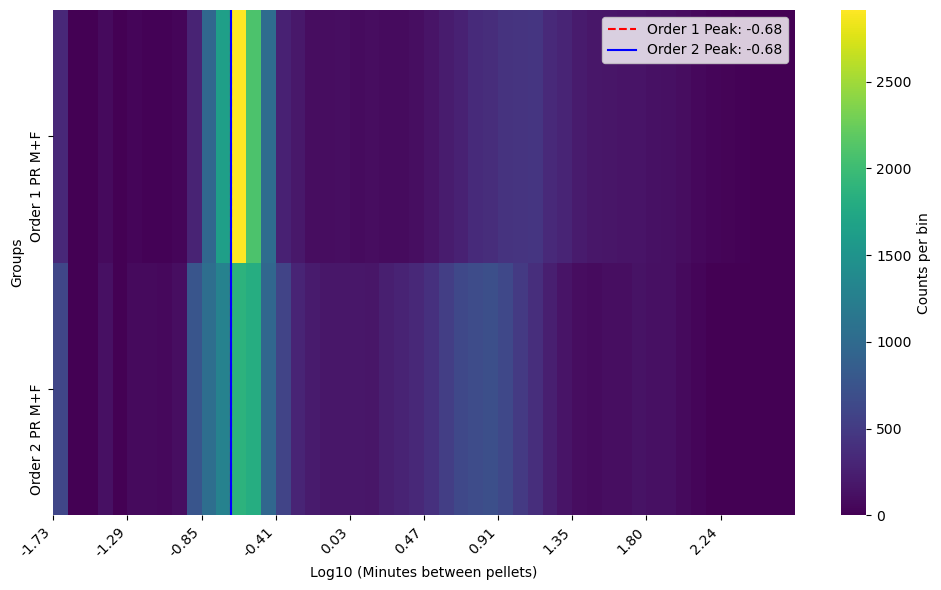

Order 1 PR Phase Most Significant Log10(minutes): -0.6753136772689792
Order 2 PR Phase Most Significant Log10(minutes): -0.6753136772689792


In [135]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def interpellet_interval_heatmap(data1, data2, ax=None, labels=["Order 1 NR M+F", "Order 2 NR M+F"], bins=50, tick_step=5, **kwargs):
    """
    Create a heatmap of inter-pellet intervals for two groups, with X-axis binned.
    Additionally, highlight the most significant bin (the bin with the highest count).
    """

    if ax is None:
        fig, ax = plt.subplots()

    # Flatten and log-transform the data for both groups
    flattened1 = tp.flatten_list(data1)
    log_transformed1 = [np.log10(val * 60) for val in flattened1 if val > 0]

    flattened2 = tp.flatten_list(data2)
    log_transformed2 = [np.log10(val * 60) for val in flattened2 if val > 0]

    # Bin the data for both groups
    hist1, bin_edges = np.histogram(log_transformed1, bins=bins)
    hist2, _ = np.histogram(log_transformed2, bins=bins)

    # Create a 2D array from the histogram data, stacking the two groups
    data_matrix = np.array([hist1, hist2])

    # Create the heatmap
    sns.heatmap(data_matrix, ax=ax, cmap="viridis", cbar_kws={'label': 'Counts per bin'}, **kwargs)

    # Set labels
    ax.set_yticks([0.5, 1.5])
    ax.set_yticklabels(labels)
    ax.set_xlabel('Log10 (Minutes between pellets)')
    ax.set_ylabel('Groups')

    # Set X-axis labels as bin centers
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Only show every nth tick to avoid label overlap
    ax.set_xticks(np.arange(0, len(bin_centers), tick_step))
    ax.set_xticklabels([f"{center:.2f}" for center in bin_centers[::tick_step]], rotation=45, ha='right')

    # Adjust the plot to prevent label overlapping
    plt.tight_layout()

    # Find the most significant bin (bin with the maximum count) for each group
    peak_bin_order1 = np.argmax(hist1)
    peak_bin_order2 = np.argmax(hist2)

    # Highlight the most significant bin by adding vertical lines
    ax.axvline(peak_bin_order1, color='red', linestyle='--', label=f"Order 1 Peak: {bin_centers[peak_bin_order1]:.2f}")
    ax.axvline(peak_bin_order2, color='blue', linestyle='-', label=f"Order 2 Peak: {bin_centers[peak_bin_order2]:.2f}")

    plt.legend()

    # Return the most significant bin (log10 of minutes)
    return ax, bin_centers[peak_bin_order1], bin_centers[peak_bin_order2]

# Fetching the data for NR phase for both orders
nr_male_order1 = get_data_fields(mice, ["pr_ipi"], {"order": 1, "sex": "M"})
nr_female_order1 = get_data_fields(mice, ["pr_ipi"], {"order": 1, "sex": "F"})
combined_nr_order1 = nr_male_order1 + nr_female_order1

nr_male_order2 = get_data_fields(mice, ["pr_ipi"], {"order": 2, "sex": "M"})
nr_female_order2 = get_data_fields(mice, ["pr_ipi"], {"order": 2, "sex": "F"})
combined_nr_order2 = nr_male_order2 + nr_female_order2

# Plotting NR phase heatmap and identifying the most significant bin
fig, ax = plt.subplots(figsize=(10, 6))

ax, peak_log10_order1, peak_log10_order2 = interpellet_interval_heatmap(combined_nr_order1, combined_nr_order2, ax=ax, 
                                       labels=["Order 1 PR M+F", "Order 2 PR M+F"], 
                                       bins=50, tick_step=5)

plt.show()

# Output the most significant bin (log10 of minutes) for each group
print(f"Order 1 PR Phase Most Significant Log10(minutes): {peak_log10_order1}")
print(f"Order 2 PR Phase Most Significant Log10(minutes): {peak_log10_order2}")


Here’s how to interpret the results from your **PR Phase heatmap**:

### **Order 1 PR Phase Most Significant Log10(minutes): -0.675**
- **Log10(minutes)**: The value **-0.675** is the log10 of the most frequent inter-pellet interval (IPI) in minutes for Order 1.
- **Converting to real minutes**: in **Order 1** during the **PR phase**, the most frequent time interval between consecutive pellets is around **12.7 seconds**.

### **Order 2 PR Phase Most Significant Log10(minutes): -0.675**
- **Log10(minutes)**: The same value appears for **Order 2**. The most frequent IPI in **Order 2** during the **PR phase** is also around **12.7 seconds**.

### **Summary**:
- For both **Order 1 and Order 2** in the **PR phase**, the most significant inter-pellet interval (the bin with the highest count in the heatmap) occurs at approximately **12.7 seconds**.
- This suggests that in the **PR phase**, both groups of mice (Order 1 and Order 2) exhibit a similar feeding pattern, where the majority of pellet retrievals occur around **12.7 seconds** apart.

### Comparison to the NR Phase:
- In the **NR phase**, the most frequent IPI was around **11.5 seconds** for both orders.
- In the **PR phase**, this interval has increased to around **12.7 seconds**.
  
This indicates that during the PR phase (protein-restricted diet), the mice are taking slightly longer intervals between consecutive pellet retrievals compared to the NR phase, suggesting that the restricted protein intake might be slowing down their feeding behavior or affecting their eating patterns, causing them to take slightly longer between feeding events.



### **KDE Plot Findings:**
- **NR Phase:**
  - **Order 1 Peak log10(minutes): -0.711**
    - Converted to real minutes: **11.7 seconds**
  - **Order 2 Peak log10(minutes): -0.701**
    - Converted to real minutes: **12.0 seconds**
  
- **PR Phase:**
  - **Order 1 Peak log10(minutes): -0.655**
    - Converted to real minutes: **13.3 seconds**
  - **Order 2 Peak log10(minutes): -0.628**
    - Converted to real minutes: **14.2 seconds**

### **Heatmap Findings (Most Significant Bin):**
- **NR Phase:**
  - **Order 1 and Order 2 log10(minutes): -0.718**
    - Converted to real minutes: **11.5 seconds**
  
- **PR Phase:**
  - **Order 1 and Order 2 log10(minutes): -0.675**
    - Converted to real minutes: **12.7 seconds**

### **Comparison and Interpretation**:
- **NR Phase**:
  - The **KDE plot** showed **11.7 seconds** for Order 1 and **12.0 seconds** for Order 2, while the **heatmap** indicated **11.5 seconds** for both groups.
  - **Conclusion**: The results are **quite consistent**. Both methods show a very similar range for the most frequent inter-pellet interval (IPI), indicating that the majority of pellet retrievals occur around **11.5–12 seconds** in the NR phase for both orders.

- **PR Phase**:
  - The **KDE plot** showed **13.3 seconds** for Order 1 and **14.2 seconds** for Order 2, while the **heatmap** indicated **12.7 seconds** for both groups.
  - **Conclusion**: There is a slight **difference** between the KDE plot and the heatmap findings in the PR phase:
    - The KDE plot shows slightly longer intervals for both orders (particularly for Order 2, at **14.2 seconds**).
    - The heatmap finds **12.7 seconds** for both orders, which is closer to the KDE value for Order 1 but shorter than the KDE value for Order 2.

### **Why the Differences?**
- **KDE plots** provide a **smooth estimate** of the probability density function (PDF) of the data, allowing us to observe **peak** patterns that reflect the **continuous distribution** of IPIs. This method is good for identifying **precise peaks** in the data.
- **Heatmaps**, on the other hand, visualize **binned frequency counts**, which give us a more **discrete view** of the data. While they show where the data is concentrated, they lack the smoothness and precision of KDE plots in identifying a peak.

### **Final Interpretation**:
The **overall trend** is consistent between both methods: in the **NR phase**, the most frequent IPI is around **11.5 to 12 seconds**, and in the **PR phase**, the intervals lengthen to around **12.7 to 14 seconds**.

The small differences (particularly in the PR phase for Order 2) arise from the inherent differences between **KDE smoothing** and **heatmap binning**. The **KDE plot** provides a more precise and detailed peak, while the **heatmap** gives a broader view of frequency distribution. 


The findings from both methods **align well**, with slight differences due to the nature of the visualization techniques. The general conclusion—that IPIs increase during the PR phase compared to the NR phase—remains consistent across both methods.

In [ ]:
import numpy as np
import pandas as pd  # Import pandas to handle DataFrame operations
import matplotlib.pyplot as plt

def flatten_list(nested_list):
    """Helper function to flatten a list of lists into a single list."""
    return [item for sublist in nested_list for item in sublist]

def cluster_pellets_by_ipi(pellettimes, ipi_threshold=60):
    """
    Cluster pellet events based on inter-pellet interval (IPI).
    """
    pellettimes = np.array(sorted(pellettimes)) * 3600  # Convert from hours to seconds and sort

    IPIs = np.diff(pellettimes)  # Calculate time differences between consecutive pellets

    # Initialize clusters
    clusters = []
    current_cluster = [pellettimes[0]]  # Start with the first pellet

    for i, ipi in enumerate(IPIs):
        if ipi <= ipi_threshold:
            current_cluster.append(pellettimes[i + 1])
        else:
            clusters.append(current_cluster)
            current_cluster = [pellettimes[i + 1]]

    if current_cluster:
        clusters.append(current_cluster)

    return clusters

def get_cluster_size_distribution_for_mouse(pellettimes, max_pellets_per_event=10):
    """
    Get the cluster size distribution for a single mouse.
    """
    clusters = cluster_pellets_by_ipi(pellettimes)
    cluster_sizes = [len(cluster) for cluster in clusters]

    # Initialize counts for cluster sizes up to max_pellets_per_event
    cluster_size_counts = {size: 0 for size in range(1, max_pellets_per_event + 1)}

    for size in cluster_sizes:
        if size <= max_pellets_per_event:
            cluster_size_counts[size] += 1
        else:
            # If size exceeds max_pellets_per_event, add to the last bin
            cluster_size_counts[max_pellets_per_event] += 1

    return cluster_size_counts

# Retrieve the list of mice for Order 1 Males on NR diet
nrpr_male_selector = {"order": 1, "sex": "M"}
selected_mice = get_data_subset(mice, nrpr_male_selector, verbose=False)

# Initialize a list to store data for each mouse
data_per_mouse = []

max_pellets_per_event = 10  # Adjust this as needed

# Process each mouse individually
for mouse_id, data in selected_mice.items():
    pellettimes = data.get("nr_timestamps", [])
    if pellettimes:
        cluster_size_counts = get_cluster_size_distribution_for_mouse(pellettimes, max_pellets_per_event)
        # Prepare the data row for this mouse
        mouse_data = {"MouseID": mouse_id}
        # Add counts for each cluster size
        for size in range(1, max_pellets_per_event + 1):
            mouse_data[f"Count_{size}"] = cluster_size_counts[size]
        data_per_mouse.append(mouse_data)
    else:
        print(f"No pellet times for mouse {mouse_id}")

# Create a DataFrame from the data
df = pd.DataFrame(data_per_mouse)

# Save the DataFrame to a CSV file
output_csv = "../results/PELLET_PINS.csv"
df.to_csv(output_csv, index=False)
print(f"Data saved to {output_csv}")

# Display the DataFrame
print(df)


Data saved to ../results/PELLET_PINS.csv
   MouseID  Count_1  Count_2  Count_3  Count_4  Count_5  Count_6  Count_7  \
0  FEDXA07       45       31       48       67       58       30       18   
1  FEDXA08       86       61       59       56       28       17       18   
2  FEDXA09       62       33       80       58       57       25       13   
3  FEDXA10       68       47       61       70       62       28       19   
4  FEDXA11      163       89       55       49       42       20       14   
5  FEDXA12      144       74       73       69       52       25       12   

   Count_8  Count_9  Count_10  
0       10        6         6  
1       10        7        15  
2       12        3         7  
3        8        6         6  
4       10        8         8  
5        7        3         6  
